In [13]:
using Pkg; Pkg.activate("../")

using YellowTripQueries
using VegaLite
using DuckDB
using DataFrames
using Markdown
using PrettyTables

# Name of DuckDB Database (File)
ydb = YellowDB("/tmp/ydb__.db")

# Location of Parquet Files
table = "parquet_scan('/Users/abisen/Desktop/data/tlc/*/*.parquet')"

  Activating project at `~/Desktop/YellowTripQueries`


"parquet_scan('/Users/abisen/Desktop/data/tlc/*/*.parquet')"

# Overview

A simple analysis of trip [record data](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page) released 
by Taxi and Limousine Commission of New York City.

# Dataset

For this analysis 11 years of data from (2011-2021) was used. The data can be downloaded
from [TLC's](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page) website in parquet format. 
There are ~1.3 Billion rows one for each trip taken, with 19 features for each record. 

## Filtering Outliers

In [17]:
result = query_passenger_count_frequency(ydb, table; plot=true)

pretty_table(result.df, tf=tf_ascii_rounded)
println("Execution took $(result.runtime) sec")

.------------.-----------.
| passengers |       cnt |
|    String? |    Int64? |
:------------+-----------:
|          0 |   7675293 |
|          1 | 925150291 |
|          2 | 189622952 |
|          3 |  55890866 |
|          4 |  26870691 |
|          5 |  73828407 |
|          6 |  37369170 |
|         7+ |      5620 |
|    missing |   2791489 |
'------------'-----------'
Execution took 3.9089495 sec


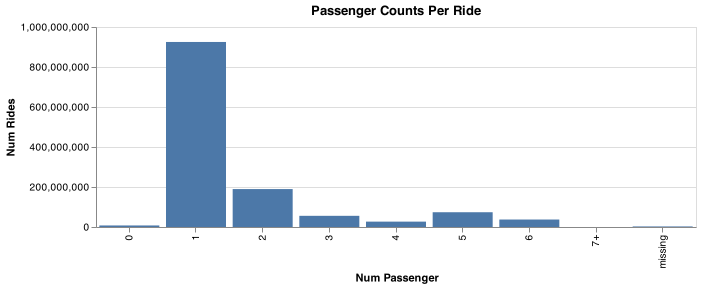

In [18]:
result.plot

In [20]:
q = "DESCRIBE SELECT * FROM $(table) LIMIT 1"
result = execute(ydb, q)

YellowTripQueries.YellowQueryResult(YellowDB("/tmp/ydb__.db", "READ_WRITE", nothing, nothing), 19×6 DataFrame
 Row │ column_name            column_type  null     key      default  extra   
     │ String?                String?      String?  String?  String?  String? 
─────┼────────────────────────────────────────────────────────────────────────
   1 │ VendorID               BIGINT       YES      missing  missing  missing 
   2 │ tpep_pickup_datetime   TIMESTAMP    YES      missing  missing  missing 
   3 │ tpep_dropoff_datetime  TIMESTAMP    YES      missing  missing  missing 
   4 │ passenger_count        BIGINT       YES      missing  missing  missing 
   5 │ trip_distance          DOUBLE       YES      missing  missing  missing 
   6 │ RatecodeID             BIGINT       YES      missing  missing  missing 
   7 │ store_and_fwd_flag     VARCHAR      YES      missing  missing  missing 
   8 │ PULocationID           BIGINT       YES      missing  missing  missing 
   9 │ DOLocationID           BIGINT       YES      missing  missing  missing 
  10 │ payment_type           BIGINT       YES      missing  missing  missing 
  11 │ fare_amount            DOUBLE       YES      missing  missing  missing 
  12 │ extra                  DOUBLE       YES      missing  missing  missing 
  13 │ mta_tax                DOUBLE       YES      missing  missing  missing 
  14 │ tip_amount             DOUBLE       YES      missing  missing  missing 
  15 │ tolls_amount           DOUBLE       YES      missing  missing  missing 
  16 │ improvement_surcharge  DOUBLE       YES      missing  missing  missing 
  17 │ total_amount           DOUBLE       YES      missing  missing  missing 
  18 │ congestion_surcharge   INTEGER      YES      missing  missing  missing 
  19 │ airport_fee            INTEGER      YES      missing  missing  missing , nothing, 0.008035542, "DESCRIBE SELECT * FROM parquet_scan('/Users/abisen/Desktop/data/tlc/*/*.parquet') LIMIT 1")

19×6 DataFrame
 Row │ column_name            column_type  null     key      default  extra   
     │ String?                String?      String?  String?  String?  String? 
─────┼────────────────────────────────────────────────────────────────────────
   1 │ VendorID               BIGINT       YES      missing  missing  missing 
   2 │ tpep_pickup_datetime   TIMESTAMP    YES      missing  missing  missing 
   3 │ tpep_dropoff_datetime  TIMESTAMP    YES      missing  missing  missing 
   4 │ passenger_count        BIGINT       YES      missing  missing  missing 
   5 │ trip_distance          DOUBLE       YES      missing  missing  missing 
   6 │ RatecodeID             BIGINT       YES      missing  missing  missing 
   7 │ store_and_fwd_flag     VARCHAR      YES      missing  missing  missing 
   8 │ PULocationID           BIGINT       YES      missing  missing  missing 
   9 │ DOLocationID           BIGINT       YES      missing  missing  missing 
  10 │ payment_type           BIGINT 

## Heatmap

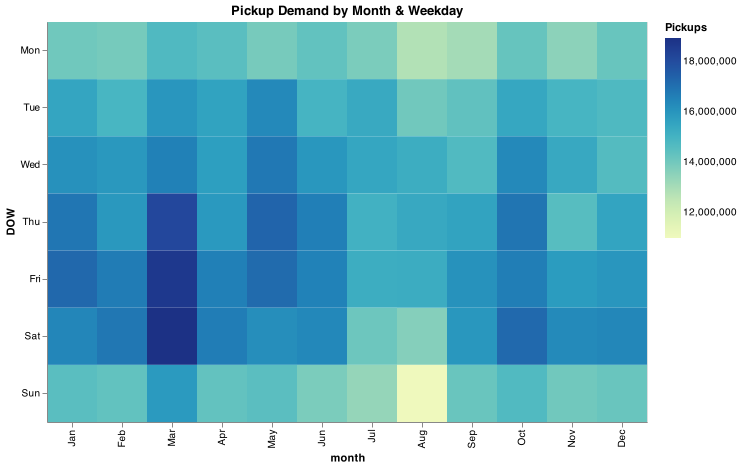

In [23]:
result = query_ridership_week_and_month(ydb, table; plot=true)
result.plot

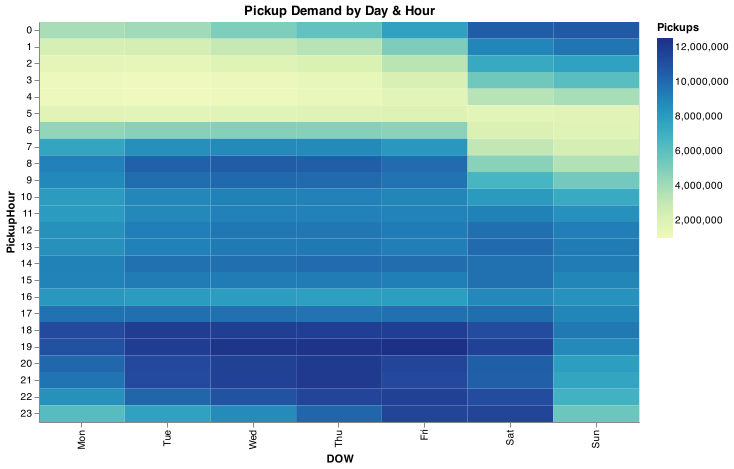

In [24]:
result = query_ridership_day_and_hour(ydb, table; plot=true)
result.plot

In [26]:
sql = """
        WITH t1 AS (
            SELECT 
                CASE 
                    WHEN tip_amount > 0 THEN 1
                    ELSE 0
                END AS tipped,
                datepart('year', tpep_pickup_datetime) as PickupYear,
                CASE 
                    WHEN payment_type = 1 THEN 'Card'
                    WHEN payment_type = 2 THEN 'Cash'
                    WHEN payment_type = 3 THEN 'No Charge'
                    WHEN payment_type = 4 THEN 'Dispute'
                    WHEN payment_type = 5 THEN 'Unknown'
                    WHEN payment_type = 6 THEN 'Voided Trip'
                    ELSE 'Unknown'
                END AS ptype,
                count(*) AS cnt,
            FROM 
                $(table)
            WHERE
                date_diff('second', tpep_pickup_datetime, tpep_dropoff_datetime) > 0     AND
                date_diff('second', tpep_pickup_datetime, tpep_dropoff_datetime) < 43200 AND
                passenger_count <= 6         AND
                passenger_count >  0         AND
                passenger_count IS NOT NULL  AND
                -- assumption: trip distances greater than 100 miles 
                -- must be for out of town hire
                trip_distance > 0            AND 
                trip_distance < 100          AND
                -- filter out non card / cash transactions
                payment_type <= 2            AND             
                -- filter out some records with incorrect date time 
                -- that falls outside the dataset range
                datepart('year', tpep_pickup_datetime) > 2010 AND
                datepart('year', tpep_pickup_datetime) < 2022
            GROUP BY PickupYear, ptype, tipped 
            )

        SELECT PickupYear, tipped, ptype, cnt,
               CAST(cnt AS FLOAT)/(sum(cnt) OVER (PARTITION BY PickupYear, ptype)) * 100 AS pct
        FROM t1
        ;
        """

df = execute(ydb, sql)

YellowTripQueries.YellowQueryResult(YellowDB("/tmp/ydb__.db", "READ_WRITE", nothing, nothing), 44×5 DataFrame
 Row │ PickupYear  tipped  ptype    cnt       pct         
     │ Int64?      Int32?  String?  Int64?    Float32?    
─────┼────────────────────────────────────────────────────
   1 │       2011       0  Card      2004618   2.69112
   2 │       2011       1  Card     72485466  97.3089
   3 │       2011       1  Cash        77537   0.0791473
   4 │       2011       0  Cash     97887881  99.9209
   5 │       2012       1  Card     79408793  97.1863
   6 │       2012       0  Card      2298974   2.81365
   7 │       2012       0  Cash     86916669  99.9603
   8 │       2012       1  Cash        34558   0.0397441
   9 │       2013       1  Card     89342394  97.0124
  10 │       2013       0  Card      2751346   2.98755
  11 │       2013       0  Cash     77800712  99.992
  ⋮  │     ⋮         ⋮        ⋮        ⋮           ⋮
  35 │       2019       0  Cash     22158219  99.9893
  36 │       2019       1  Cash         2372   0.0107037
  37 │       2020       1  Card     16346246  96.8612
  38 │       2020       0  Card       529699   3.13878
  39 │       2020       1  Cash          670   0.0112899
  40 │       2020       0  Cash      5933814  99.9887
  41 │       2021       0  Card       772749   3.56025
  42 │       2021       1  Card     20932143  96.4398
  43 │       2021       1  Cash          648   0.0101326
  44 │       2021       0  Cash      6394547  99.9899
                                           23 rows omitted, nothing, 38.8870475, "WITH t1 AS (\n    SELECT \n        CASE \n            WHEN tip_amount > 0 THEN 1\n            ELSE 0\n        END AS tipped,\n        datepart('year', tpep_pickup_datetime) as PickupYear,\n        CASE \n            WHEN payment_type = 1 THEN 'Card'\n            WHEN payment_type = 2 THEN 'Cash'\n            WHEN payment_type = 3 THEN 'No Charge'\n            WHEN payment_type = 4 THEN 'Dispute'\n            WHEN payment_type = 5 THEN 'Unknown'\n            WHEN payment_type = 6 THEN 'Voided Trip'\n            ELSE 'Unknown'\n        END AS ptype,\n        count(*) AS cnt,\n    FROM \n        parquet_scan('/Users/abisen/Desktop/data/tlc/*/*.parquet')\n    WHERE\n        date_diff('second', tpep_pickup_datetime, tpep_dropoff_datetime) > 0     AND\n        date_diff('second', tpep_pickup_datetime, tpep_dropoff_datetime) < 43200 AND\n        passenger_count <= 6         AND\n        passenger_count >  0         AND\n        passenger_count IS NOT NULL  AND\n        -- assumption: trip distances greater than 100 miles \n        -- must be for out of town hire\n        trip_distance > 0            AND \n        trip_distance < 100          AND\n        -- filter out non card / cash transactions\n        payment_type <= 2            AND             \n        -- filter out some records with incorrect date time \n        -- that falls outside the dataset range\n        datepart('year', tpep_pickup_datetime) > 2010 AND\n        datepart('year', tpep_pickup_datetime) < 2022\n    GROUP BY PickupYear, ptype, tipped \n    )\n\nSELECT PickupYear, tipped, ptype, cnt,\n       CAST(cnt AS FLOAT)/(sum(cnt) OVER (PARTITION BY PickupYear, ptype)) * 100 AS pct\nFROM t1\n;\n")

44×5 DataFrame
 Row │ PickupYear  tipped  ptype    cnt       pct         
     │ Int64?      Int32?  String?  Int64?    Float32?    
─────┼────────────────────────────────────────────────────
   1 │       2011       0  Card      2004618   2.69112
   2 │       2011       1  Card     72485466  97.3089
   3 │       2011       1  Cash        77537   0.0791473
   4 │       2011       0  Cash     97887881  99.9209
   5 │       2012       1  Card     79408793  97.1863
   6 │       2012       0  Card      2298974   2.81365
   7 │       2012       0  Cash     86916669  99.9603
   8 │       2012       1  Cash        34558   0.0397441
   9 │       2013       1  Card     89342394  97.0124
  10 │       2013       0  Card      2751346   2.98755
  11 │       2013       0  Cash     77800712  99.992
  ⋮  │     ⋮         ⋮        ⋮        ⋮           ⋮
  35 │       2019       0  Cash     22158219  99.9893
  36 │       2019       1  Cash         2372   0.0107037
  37 │       2020       1  Card     163462

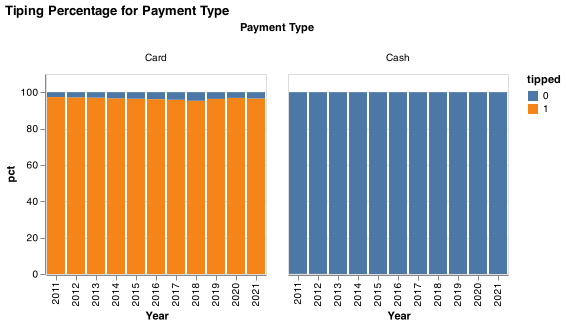

In [49]:
df |> DataFrame |> @vlplot(
        mark = {:bar, tooltip=true},
        x = {:PickupYear, type="ordinal", title = "Year"},
        y = {:pct},
        color = {:tipped, type="nominal"},
        column={:ptype, type="ordinal", title="Payment Type"},
        title="Tiping Percentage for Payment Type"
    )

In [7]:
res = query_tip_ratio_payment_type(ydb, table; plot=true)

YellowTripQueries.YellowQueryResult(YellowDB("/tmp/ydb__.db", "READ_WRITE", nothing, nothing), 44×5 DataFrame
 Row │ PickupYear  tipped  ptype    cnt       pct         
     │ Int64?      Int32?  String?  Int64?    Float32?    
─────┼────────────────────────────────────────────────────
   1 │       2011       0  Card      2004618   2.69112
   2 │       2011       1  Card     72485466  97.3089
   3 │       2011       1  Cash        77537   0.0791473
   4 │       2011       0  Cash     97887881  99.9209
   5 │       2012       1  Card     79408793  97.1863
   6 │       2012       0  Card      2298974   2.81365
   7 │       2012       0  Cash     86916669  99.9603
   8 │       2012       1  Cash        34558   0.0397441
   9 │       2013       1  Card     89342394  97.0124
  10 │       2013       0  Card      2751346   2.98755
  11 │       2013       0  Cash     77800712  99.992
  ⋮  │     ⋮         ⋮        ⋮        ⋮           ⋮
  35 │       2019       0  Cash     22158219  99.9893
  36 │       2019       1  Cash         2372   0.0107037
  37 │       2020       1  Card     16346246  96.8612
  38 │       2020       0  Card       529699   3.13878
  39 │       2020       1  Cash          670   0.0112899
  40 │       2020       0  Cash      5933814  99.9887
  41 │       2021       0  Card       772749   3.56025
  42 │       2021       1  Card     20932143  96.4398
  43 │       2021       1  Cash          648   0.0101326
  44 │       2021       0  Cash      6394547  99.9899
                                           23 rows omitted, VegaLite.VLSpec, 39.752481459, "    WITH t1 AS (\n        SELECT \n            CASE \n                WHEN tip_amount > 0 THEN 1\n                ELSE 0\n            END AS tipped,\n            datepart('year', tpep_pickup_datetime) as PickupYear,\n            CASE \n                WHEN payment_type = 1 THEN 'Card'\n                WHEN payment_type = 2 THEN 'Cash'\n                WHEN payment_type = 3 THEN 'No Charge'\n                WHEN payment_type = 4 THEN 'Dispute'\n                WHEN payment_type = 5 THEN 'Unknown'\n                WHEN payment_type = 6 THEN 'Voided Trip'\n                ELSE 'Unknown'\n            END AS ptype,\n            count(*) AS cnt,\n        FROM \n            parquet_scan('/Users/abisen/Desktop/data/tlc/*/*.parquet')\n        WHERE\n            date_diff('second', tpep_pickup_datetime, tpep_dropoff_datetime) > 0     AND\n            date_diff('second', tpep_pickup_datetime, tpep_dropoff_datetime) < 43200 AND\n            passenger_count <= 6         AND\n            passenger_count >  0         AND\n            passenger_count IS NOT NULL  AND\n            -- assumption: trip distances greater than 100 miles \n            -- must be for out of town hire\n            trip_distance > 0            AND \n            trip_distance < 100          AND\n            -- filter out non card / cash transactions\n            payment_type <= 2            AND             \n            -- filter out some records with incorrect date time \n            -- that falls outside the dataset range\n            datepart('year', tpep_pickup_datetime) > 2010 AND\n            datepart('year', tpep_pickup_datetime) < 2022\n        GROUP BY PickupYear, ptype, tipped \n        )\n\n    SELECT PickupYear, tipped, ptype, cnt,\n           CAST(cnt AS FLOAT)/(sum(cnt) OVER (PARTITION BY PickupYear, ptype)) * 100 AS pct\n    FROM t1\n    ;\n")

44×5 DataFrame
 Row │ PickupYear  tipped  ptype    cnt       pct         
     │ Int64?      Int32?  String?  Int64?    Float32?    
─────┼────────────────────────────────────────────────────
   1 │       2011       0  Card      2004618   2.69112
   2 │       2011       1  Card     72485466  97.3089
   3 │       2011       1  Cash        77537   0.0791473
   4 │       2011       0  Cash     97887881  99.9209
   5 │       2012       1  Card     79408793  97.1863
   6 │       2012       0  Card      2298974   2.81365
   7 │       2012       0  Cash     86916669  99.9603
   8 │       2012       1  Cash        34558   0.0397441
   9 │       2013       1  Card     89342394  97.0124
  10 │       2013       0  Card      2751346   2.98755
  11 │       2013       0  Cash     77800712  99.992
  ⋮  │     ⋮         ⋮        ⋮        ⋮           ⋮
  35 │       2019       0  Cash     22158219  99.9893
  36 │       2019       1  Cash         2372   0.0107037
  37 │       2020       1  Card     163462

In [21]:
q = """
    SELECT  datepart('hour', tpep_pickup_datetime) as PickupHour, 
            CASE 
                WHEN datepart('dow', tpep_pickup_datetime) = 0 THEN 'Sun'
                WHEN datepart('dow', tpep_pickup_datetime) = 1 THEN 'Mon'
                WHEN datepart('dow', tpep_pickup_datetime) = 2 THEN 'Tue'
                WHEN datepart('dow', tpep_pickup_datetime) = 3 THEN 'Wed'
                WHEN datepart('dow', tpep_pickup_datetime) = 4 THEN 'Thu'
                WHEN datepart('dow', tpep_pickup_datetime) = 5 THEN 'Fri'
                WHEN datepart('dow', tpep_pickup_datetime) = 6 THEN 'Sat'
            END AS DOW,
            count(*) as count 
    FROM $(table) 
    WHERE
        date_diff('second', tpep_pickup_datetime, tpep_dropoff_datetime) > 0     AND
        date_diff('second', tpep_pickup_datetime, tpep_dropoff_datetime) < 43200 AND
        passenger_count <= 6         AND
        passenger_count >  0         AND
        passenger_count IS NOT NULL  AND
        -- assumption: trip distances greater than 100 miles 
        -- must be for out of town hire
        trip_distance > 0            AND 
        trip_distance < 100          AND
        -- filter out non card / cash transactions
        payment_type <= 2            AND             
        -- filter out some records with incorrect date time 
        -- that falls outside the dataset range
        datepart('year', tpep_pickup_datetime) > 2010 AND
        datepart('year', tpep_pickup_datetime) < 2022
    GROUP BY
        DOW, PickupHour
    ORDER BY DOW;
    ;
"""



result = execute(ydb, q)

YellowTripQueries.YellowQueryResult(YellowDB("/tmp/ydb__.db", "READ_WRITE", nothing, nothing), 168×3 DataFrame
 Row │ PickupHour  DOW      count    
     │ Int64?      String?  Int64?   
─────┼───────────────────────────────
   1 │          1  Fri       5071352
   2 │          4  Fri       1747313
   3 │         20  Fri      11543572
   4 │         13  Fri       9199654
   5 │          8  Fri       9924148
   6 │          7  Fri       8151064
   7 │          2  Fri       3340041
   8 │          0  Fri       7713682
   9 │          5  Fri       1971338
  10 │          6  Fri       4654198
  11 │          9  Fri       9609446
  ⋮  │     ⋮          ⋮        ⋮
 159 │         14  Wed       9765416
 160 │         13  Wed       9358019
 161 │         12  Wed       9474341
 162 │          7  Wed       8735288
 163 │         20  Wed      11702535
 164 │         11  Wed       9084753
 165 │          9  Wed       9993648
 166 │         22  Wed      10881972
 167 │         21  Wed      11672256
 168 │         19  Wed      12250936
                     147 rows omitted, nothing, 155.310630167, "    SELECT  datepart('hour', tpep_pickup_datetime) as PickupHour, \n            CASE \n                WHEN datepart('dow', tpep_pickup_datetime) = 0 THEN 'Sun'\n                WHEN datepart('dow', tpep_pickup_datetime) = 1 THEN 'Mon'\n                WHEN datepart('dow', tpep_pickup_datetime) = 2 THEN 'Tue'\n                WHEN datepart('dow', tpep_pickup_datetime) = 3 THEN 'Wed'\n                WHEN datepart('dow', tpep_pickup_datetime) = 4 THEN 'Thu'\n                WHEN datepart('dow', tpep_pickup_datetime) = 5 THEN 'Fri'\n                WHEN datepart('dow', tpep_pickup_datetime) = 6 THEN 'Sat'\n            END AS DOW,\n            count(*) as count \n    FROM parquet_scan('/Users/abisen/Desktop/data/tlc/*/*.parquet') \n    WHERE\n        date_diff('second', tpep_pickup_datetime, tpep_dropoff_datetime) > 0     AND\n        date_diff('second', tpep_pickup_datetime, tpep_dropoff_datetime) < 43200 AND\n        passenger_count <= 6         AND\n        passenger_count >  0         AND\n        passenger_count IS NOT NULL  AND\n        -- assumption: trip distances greater than 100 miles \n        -- must be for out of town hire\n        trip_distance > 0            AND \n        trip_distance < 100          AND\n        -- filter out non card / cash transactions\n        payment_type <= 2            AND             \n        -- filter out some records with incorrect date time \n        -- that falls outside the dataset range\n        datepart('year', tpep_pickup_datetime) > 2010 AND\n        datepart('year', tpep_pickup_datetime) < 2022\n    GROUP BY\n        DOW, PickupHour\n    ORDER BY DOW;\n    ;\n")

168×3 DataFrame
 Row │ PickupHour  DOW      count    
     │ Int64?      String?  Int64?   
─────┼───────────────────────────────
   1 │          1  Fri       5071352
   2 │          4  Fri       1747313
   3 │         20  Fri      11543572
   4 │         13  Fri       9199654
   5 │          8  Fri       9924148
   6 │          7  Fri       8151064
   7 │          2  Fri       3340041
   8 │          0  Fri       7713682
   9 │          5  Fri       1971338
  10 │          6  Fri       4654198
  11 │          9  Fri       9609446
  ⋮  │     ⋮          ⋮        ⋮
 159 │         14  Wed       9765416
 160 │         13  Wed       9358019
 161 │         12  Wed       9474341
 162 │          7  Wed       8735288
 163 │         20  Wed      11702535
 164 │         11  Wed       9084753
 165 │          9  Wed       9993648
 166 │         22  Wed      10881972
 167 │         21  Wed      11672256
 168 │         19  Wed      12250936
                     147 rows omitted

Execution Time: 155.3

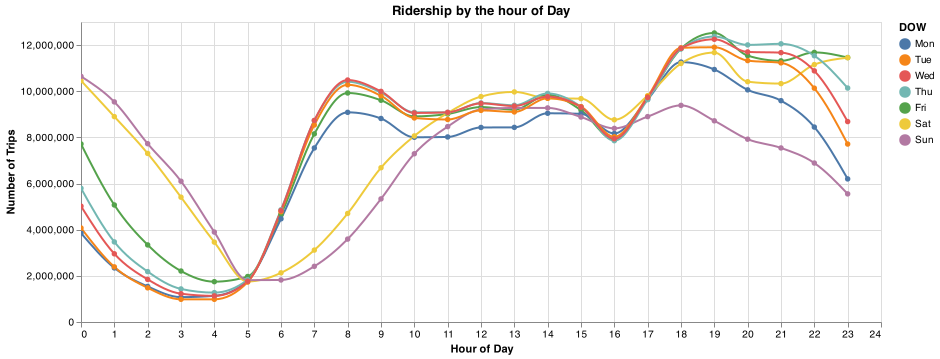

In [36]:
result.df |> @vlplot(
            mark = {:line, tooltip=true, interpolate="monotone", point=true},
            x={:PickupHour, title="Hour of Day", scale={zero=false}},
            y={:count, title="Number of Trips"},
            color={
                    :DOW, 
                    type="nominal",
                    sort = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
                    },
            width=800, height=300,
            title = "Ridership by the hour of Day",
            selection={
                        view={type=:interval, bind=:scales}
                    }
        )

In [45]:
hstr = """
    <script src="https://cdn.plot.ly/plotly-2.16.1.min.js"></script>
    <div id="tester" style="width:600px;height:450px;"></div>
    <script>
        var trace1 = {
          x: ['giraffes', 'orangutans', 'monkeys'],
          y: [20, 14, 23],
          name: 'SF Zoo',
          type: 'bar'
        };

        var trace2 = {
          x: ['giraffes', 'orangutans', 'monkeys'],
          y: [12, 18, 29],
          name: 'LA Zoo',
          type: 'bar'
        };
        var data = [trace1, trace2];
        var layout = {barmode: 'group'};
        Plotly.newPlot('tester', data, layout);
    </script>
"""

"    <script src=\"https://cdn.plot.ly/plotly-2.16.1.min.js\"></script>\n    <div id=\"tester\" style=\"width:600px;height:450px;\"></div>\n    <script>\n        var trace1 = {\n          x: ['giraffes', 'orangutans', 'monkeys'],\n          y: [20, 14, 23],\n          name: 'SF Zoo'," ⋯ 65 bytes ⋯ "   x: ['giraffes', 'orangutans', 'monkeys'],\n          y: [12, 18, 29],\n          name: 'LA Zoo',\n          type: 'bar'\n        };\n        var data = [trace1, trace2];\n        var layout = {barmode: 'group'};\n        Plotly.newPlot('tester', data, layout);\n    </script>\n"

In [46]:
HTML(hstr)

HTML{String}("    <script src=\"https://cdn.plot.ly/plotly-2.16.1.min.js\"></script>\n    <div id=\"tester\" style=\"width:600px;height:450px;\"></div>\n    <script>\n        var trace1 = {\n          x: ['giraffes', 'orangutans', 'monkeys'],\n          y: [20, 14, 23],\n          name: 'SF Zoo',\n          type: 'bar'\n        };\n\n        var trace2 = {\n          x: ['giraffes', 'orangutans', 'monkeys'],\n          y: [12, 18, 29],\n          name: 'LA Zoo',\n          type: 'bar'\n        };\n        var data = [trace1, trace2];\n        var layout = {barmode: 'group'};\n        Plotly.newPlot('tester', data, layout);\n    </script>\n")